In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

#### Docs : https://modal-python.readthedocs.io/en/latest/content/examples/ensemble_regression.html

In [3]:
# generating the data
X = np.concatenate((np.random.rand(100)-1, np.random.rand(100)))
y = np.abs(X) + np.random.normal(scale=0.2, size=X.shape)

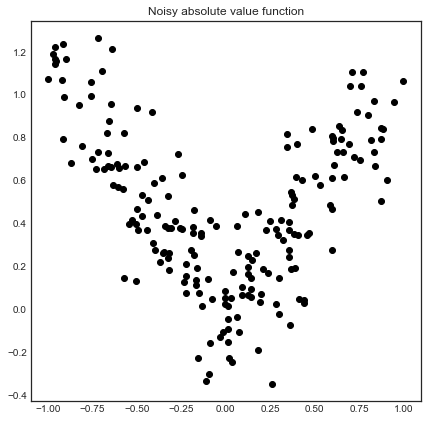

In [9]:
# visualizing the data
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.scatter(X, y, c='k')
    plt.title('Noisy absolute value function')
    plt.show()

## Active regression



In [14]:
# initializing the regressors
n_initial = 10
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

initial_idx = list()
initial_idx.append(np.random.choice(range(100), size=n_initial, replace=False))
initial_idx.append(np.random.choice(range(100, 200), size=n_initial, replace=False))
learner_list = [ActiveLearner(
                        estimator=GaussianProcessRegressor(kernel),
                        X_training=X[idx].reshape(-1, 1), y_training=y[idx].reshape(-1, 1)
                )
                for idx in initial_idx]

In [15]:
# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

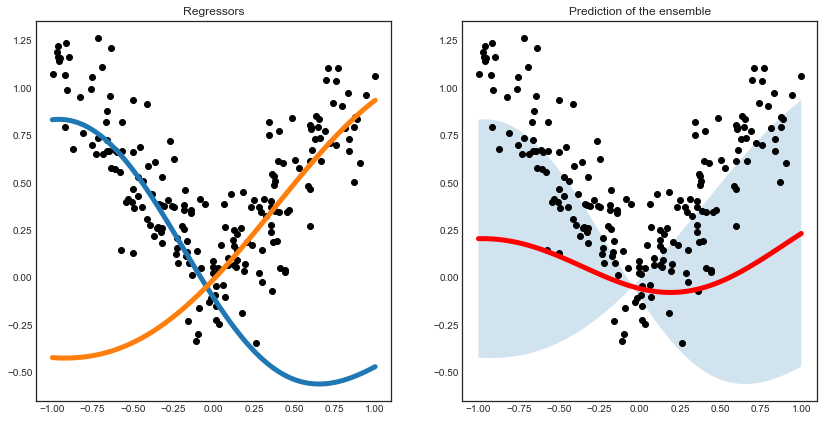

In [16]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors')

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble')
    plt.show()

In [17]:
# active regression
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X.reshape(-1, 1))
    committee.teach(X[query_idx].reshape(-1, 1), y[query_idx].reshape(-1, 1))

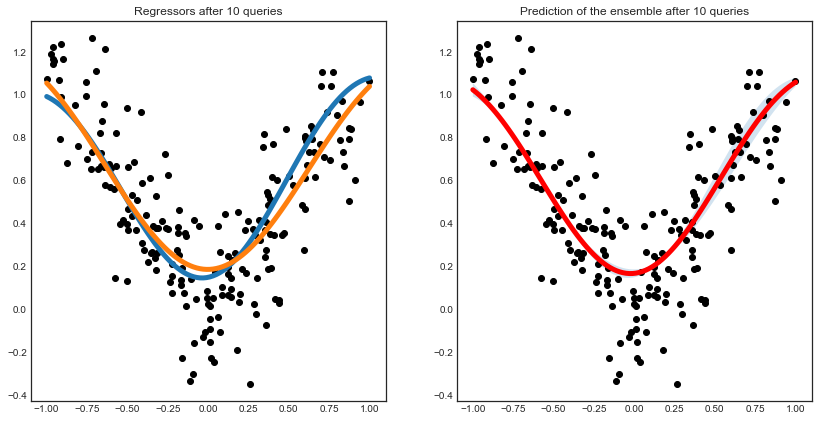

In [18]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors after %d queries' % n_queries)

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble after %d queries' % n_queries)
    plt.show()